# Packages

In [1]:
pwd

'/home/luismaecker/team-extra/imke&luis&moritz'

In [1]:
import xcube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regionmask
import seaborn as sns
from scalecast.Forecaster import Forecaster
from scalecast.SeriesTransformer import SeriesTransformer
from sklearn.preprocessing import MinMaxScaler

from xcube.core.store import new_data_store
from keras.optimizers import Adam

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

/home/luismaecker/.conda/envs/sif_env/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
2024-06-14 21:01:42.896183: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 21:01:46.386964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import lexcube

# Functions

In [3]:
# Added y asynchron with t-1 at Xt to X
def convert2matrix(data_arr, look_back):
    X, Y = [], []
    for i in range(1, len(data_arr) - look_back):
        d = i + look_back  
        # Append the feature columns and also include the target column shifted by one.
        # It creates a new array from the feature columns and the lagged target column.
        x_seq = np.array(data_arr[i:d, :-1])

        y_shifted =np.array(data_arr[(i-1):(d-1), -1]).reshape((-1,1))

        assert x_seq.shape[0] == y_shifted.shape[0]

        x_sequence = np.hstack([x_seq, y_shifted])
        
        X.append(x_sequence)
        # Target: the value at the d-th position (assumes target is the last column)
        Y.append(data_arr[d-1, -1])
    return np.array(X), np.array(Y)


In [4]:
def df_preprocess(df, variables):
    # Reset index to have a single time index
    df = df.reset_index(inplace=False)

    df = df.sort_values('time')

    # remove nan 
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Convert the numerical columns to float32 type for compatibility with Keras
    df[variables] = df[variables].astype('float32')



    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    all_data_scaled = scaler.fit_transform(df[variables])

    # Convert the scaled data back to a DataFrame for easier manipulation
    all_data_scaled = pd.DataFrame(all_data_scaled, columns=variables)
    all_data_scaled['time'] = df['time'].values  # Preserve the time column
    all_data_scaled['lat'] = df['lat'].values  # Preserve the time column
    all_data_scaled['lon'] = df['lon'].values  # Preserve the time column


    return all_data_scaled

In [55]:

def split(df_scaled,lat, lon, look_back):

    # Correct usage of .loc with conditions
    df_scaled = df_scaled.loc[(df_scaled['lat'] == lat) & (df_scaled['lon'] == lon)]

    # Split the data into training, validation, and testing sets based on the year
    train_data = df_scaled[df_scaled['time'].dt.year <= 2015]
    val_data = df_scaled[(df_scaled['time'].dt.year == 2016) | (df_scaled['time'].dt.year == 2017)]
    test_data = df_scaled[df_scaled['time'].dt.year >= 2018]

    test_index = sorted(list(set(test_data.time)))

    # Drop the 'time' column for training, validation, and testing
    train = train_data.drop(columns=['time',"lat","lon"]).values
    val = val_data.drop(columns=['time',"lat","lon"]).values
    test = test_data.drop(columns=['time',"lat","lon"]).values


    print(f'Train shape: {train.shape}')
    print(f'Validation shape: {val.shape}')
    print(f'Test shape: {test.shape}')


    # Convert the training, validation, and testing data to the required format for LSTM
    trainX, trainY = convert2matrix(train, look_back)
    valX, valY = convert2matrix(val, look_back)
    testX, testY = convert2matrix(test, look_back)

    print(f'TrainX shape: {trainX.shape}, TrainY shape: {trainY.shape}')
    print(f'ValX shape: {valX.shape}, ValY shape: {valY.shape}')
    print(f'TestX shape: {testX.shape}, TestY shape: {testY.shape}')

    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
    valX = np.reshape(valX, (valX.shape[0], valX.shape[1], valX.shape[2]))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

    print(f'Reshaped TrainX shape: {trainX.shape}')
    print(f'Reshaped ValX shape: {valX.shape}')
    print(f'Reshaped TestX shape: {testX.shape}')

    # Assuming train, test, val, and all_data are already defined
    total_rows = train.shape[0] + test.shape[0] + val.shape[0]
    assert total_rows == df_scaled.shape[0], f"The shapes do not match. Sum of train, test, and val rows: {total_rows}, all_data rows: {all_data.shape[0]}"


    return trainX, trainY, valX, valY, testX, testY, test_index


In [6]:
def improved_model_lstm(look_back, features, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(128, input_shape=(look_back, features), activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(64))
    #model.add(Dropout(0.1))
    # model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse', 'mae'])
    return model

# Define the LSTM model
def model_lstm(look_back, features):
    model = Sequential()
    # LSTM layer with 100 units, input_shape specifies the time steps and features
    model.add(LSTM(128, input_shape=(look_back, features), activation='relu'))
    # Dense layer with 1 unit for the output (predicting one value)
    model.add(Dense(64))
    model.add(Dense(1))

    # Compile the model with mean squared error loss and Adam optimizer
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model


In [7]:
# Train the model
def run_model(trainX, trainY, valX, valY, look_back, epochs, learning_rate=0.001, batch_size=32):

    num_features = trainX.shape[2]
    model = improved_model_lstm(look_back, num_features, learning_rate)
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(valX, valY), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)
    return model, history

In [8]:
def plot_training(history):
    # Plot training & validation loss values
    plt.figure(figsize=(14, 7))

    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Loss and Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Metric')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


In [9]:

# Iterative prediction and substitution
def predict_replace(model, X_test):
    forecasts = []

    for i in range(len(X_test)):
        print(i)
        forecast = model.predict(X_test[i].reshape(1, look_back, -1))
        forecasts.append(forecast[0][0])  # Ensure forecasts are appended to the list correctly

        # Update the next sample if it's not the last one in the dataset
        if i < len(X_test) - 1:

        # Move all previous values one position to the left and place the new forecast at the end
            X_test[i+1, :-1, -1] = X_test[i+1, 1:, -1]  # Shift all but the last element to the left
            X_test[i+1, -1, -1] = forecast[0][0]  # Insert the latest forecast at the end
    
    forecasts_array = np.array(forecasts)
    return forecasts_array
    

In [10]:

# Evaluation function for model performance
def evaluate_model(true_values, predicted_values, data_type='Train'):
    """
    Evaluates the model performance by calculating RMSE and MAE.

    Parameters:
    true_values (np.array): Array of true values.
    predicted_values (np.array): Array of predicted values.
    data_type (str): Type of data being evaluated (Train/Test). Default is 'Train'.

    Returns:
    None
    """
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mae = mean_absolute_error(true_values, predicted_values)
    print(f'{data_type} Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'{data_type} Mean Absolute Error (MAE): {mae:.2f}')


In [11]:
# Evaluation function for model performance
def evaluate_model(true_values, predicted_values, data_type='Validation'):
    # Remove NaN values
    mask = ~np.isnan(predicted_values)
    print(mask.shape)
    print(true_values.shape)
    
    true_values = true_values[mask]
    predicted_values = predicted_values[mask]
    
    if len(true_values) > 0 and len(predicted_values) > 0:
        rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
        mae = mean_absolute_error(true_values, predicted_values)
        print(f'{data_type} Root Mean Squared Error (RMSE): {rmse:.2f}')
        print(f'{data_type} Mean Absolute Error (MAE): {mae:.2f}')
    else:
        print(f'{data_type} evaluation skipped due to insufficient data.')

In [21]:
def eval_full(testY, forecasts, look_back, test_index):
    evaluate_model(testY, forecasts, 'Test')
    # Plot the true vs predicted SIF values for the test data
    plt.figure(figsize=(14, 7))
    plt.plot(test_index[(look_back+1):], testY, label='True SIF')
    plt.plot(test_index[(look_back+1):], forecasts, label='With replacement Predicted SIF')
    plt.legend()
    plt.show()


# Model multiple timeseries

## Subset Data

### Load and subset cube

In [22]:
store = new_data_store("s3", root="deep-esdl-public", storage_options=dict(anon=True))
store.list_data_ids()


cube = store.open_data( 'esdc-8d-0.25deg-256x128x128-3.0.1.zarr')

cube = cube.sel(time=slice('2002-01-01','2021-12-31'))

lon_min, lon_max = 5.866, 15.042
lat_min, lat_max = 47.270, 55.058

cube_ger = cube.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

In [24]:

w = lexcube.Cube3DWidget(cube_ger.sif_gosif, cmap="viridis", vmin=0, vmax=0.7)#
w

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…

In [25]:
variables = ["evaporation_era5",
            "precipitation_era5", 
            "radiation_era5", 
            "air_temperature_2m", 
            "max_air_temperature_2m", 
            "min_air_temperature_2m",
            "sif_gosif"]

In [26]:
#TODO: Select only 5 samples - run model once with unified model, once with local

# Initialize an empty list to hold all time series data
all_data_list = []

# Iterate over a selection of lat and lon points within the bounds
for lat in range(0, cube_ger.lat.size, 15):  # adjust step as necessary
    for lon in range(0, cube_ger.lon.size, 15):  # adjust step as necessary
        ts = cube_ger[variables].isel(lat=lat, lon=lon).to_dataframe()
        all_data_list.append(ts)

# Concatenate all the dataframes in the list into a single DataFrame
all_data = pd.concat(all_data_list)

In [27]:
all_data_scaled = df_preprocess(all_data, variables)
all_data_scaled

,evaporation_era5,precipitation_era5,radiation_era5,air_temperature_2m,max_air_temperature_2m,min_air_temperature_2m,sif_gosif,time,lat,lon
0,0.925244,0.000006,0.184041,0.279846,0.209789,0.399398,0.040212,2002-01-05,47.375,5.875
1,0.963574,0.018695,0.123916,0.074519,0.050559,0.119800,0.010344,2002-01-05,47.375,13.375
2,0.927833,0.006081,0.088067,0.316265,0.221296,0.423778,0.033805,2002-01-05,51.125,5.875
3,0.943090,0.000190,0.136538,0.073581,0.084696,0.138622,0.007272,2002-01-05,47.375,9.625
4,0.954242,0.015030,0.052155,0.228357,0.150983,0.148983,0.034536,2002-01-05,51.125,9.625
...,...,...,...,...,...,...,...,...,...,...
6435,0.969065,0.264250,0.079311,0.335260,0.279039,0.427541,0.036090,2021-12-31,47.375,13.375
6436,0.903866,0.113528,0.045996,0.466460,0.431787,0.499171,0.038899,2021-12-31,51.125,13.375
6437,0.859585,0.159143,0.036873,0.575104,0.443991,0.686860,0.060786,2021-12-31,51.125,5.875
6438,0.832616,0.385393,0.049752,0.562779,0.453843,0.696623,0.072194,2021-12-31,47.375,5.875


## train and test split

In [28]:
look_back = 30


## Model and predict

In [56]:
lat = 47.375
lon = 5.875
#df_scaled = all_data_scaled.loc[(df['lat'] == lat) & (df['lon'] == lon)]

trainX, trainY, valX, valY, testX, testY, test_index  = split(all_data_scaled,lat, lon, look_back = look_back)


Train shape: (644, 7)
Validation shape: (92, 7)
Test shape: (184, 7)
TrainX shape: (613, 30, 7), TrainY shape: (613,)
ValX shape: (61, 30, 7), ValY shape: (61,)
TestX shape: (153, 30, 7), TestY shape: (153,)
Reshaped TrainX shape: (613, 30, 7)
Reshaped ValX shape: (61, 30, 7)
Reshaped TestX shape: (153, 30, 7)


In [30]:
look_back = 30
epochs = 100

In [57]:
model, history = run_model(trainX, trainY, valX, valY, look_back=look_back, epochs = 100)


Epoch 1/100


/home/luismaecker/.conda/envs/sif_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0811 - mae: 0.2289 - mse: 0.0811 - val_loss: 0.0165 - val_mae: 0.0967 - val_mse: 0.0165
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0143 - mae: 0.0851 - mse: 0.0143 - val_loss: 0.0043 - val_mae: 0.0468 - val_mse: 0.0043
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0069 - mae: 0.0627 - mse: 0.0069 - val_loss: 0.0041 - val_mae: 0.0479 - val_mse: 0.0041
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - mae: 0.0582 - mse: 0.0063 - val_loss: 0.0038 - val_mae: 0.0462 - val_mse: 0.0038
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - mae: 0.0505 - mse: 0.0049 - val_loss: 0.0038 - val_mae: 0.0486 - val_mse: 0.0038
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - mae: 0.0486 - mse: 0.0044 - val_loss: 0.0035 - val_mae: 0.0461 - val_mse: 0.0035
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - mae: 0.0470 - mse: 0.0041 - val_loss: 0.003

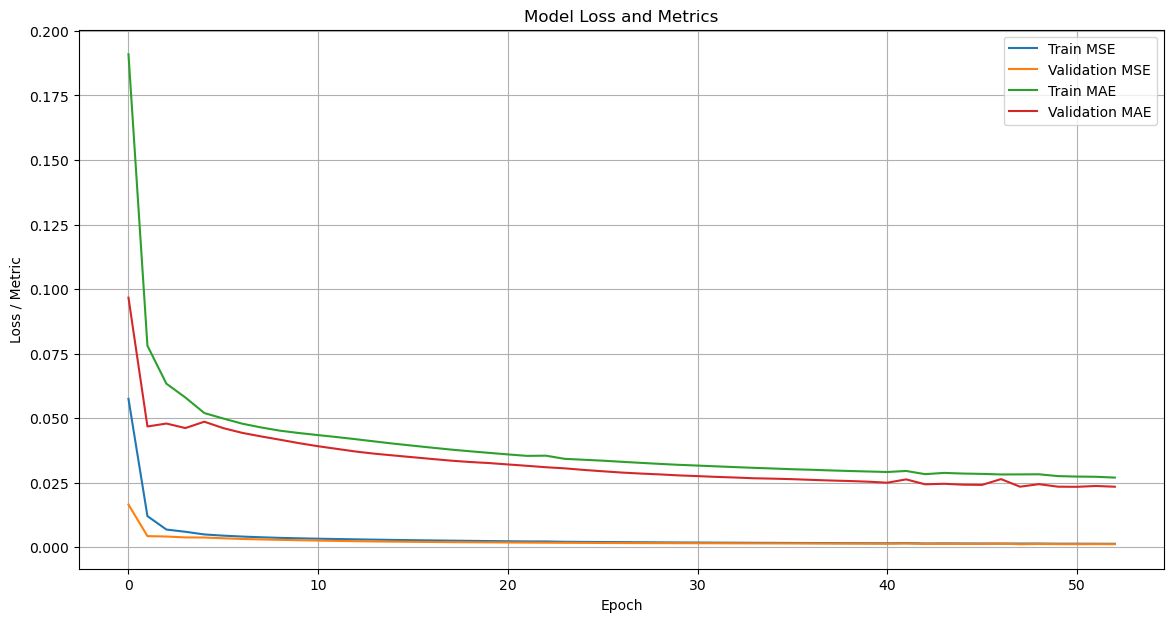

In [58]:
plot_training(history)


In [33]:
forecasts = predict_replace(model, testX)


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━━

In [34]:
testY.shape

(153,)

In [35]:
len(test_index)

184

In [36]:
forecasts.shape

(153,)

In [37]:
#evaluate_model(trainY, train_predict[:, 0], 'Train')
evaluate_model(testY, forecasts[:], 'Test')


(153,)
(153,)
Test Root Mean Squared Error (RMSE): 0.04
Test Mean Absolute Error (MAE): 0.03


In [39]:
np.array(test_index).shape

(184,)

In [40]:
testY.shape

(153,)

In [41]:
forecasts.shape

(153,)

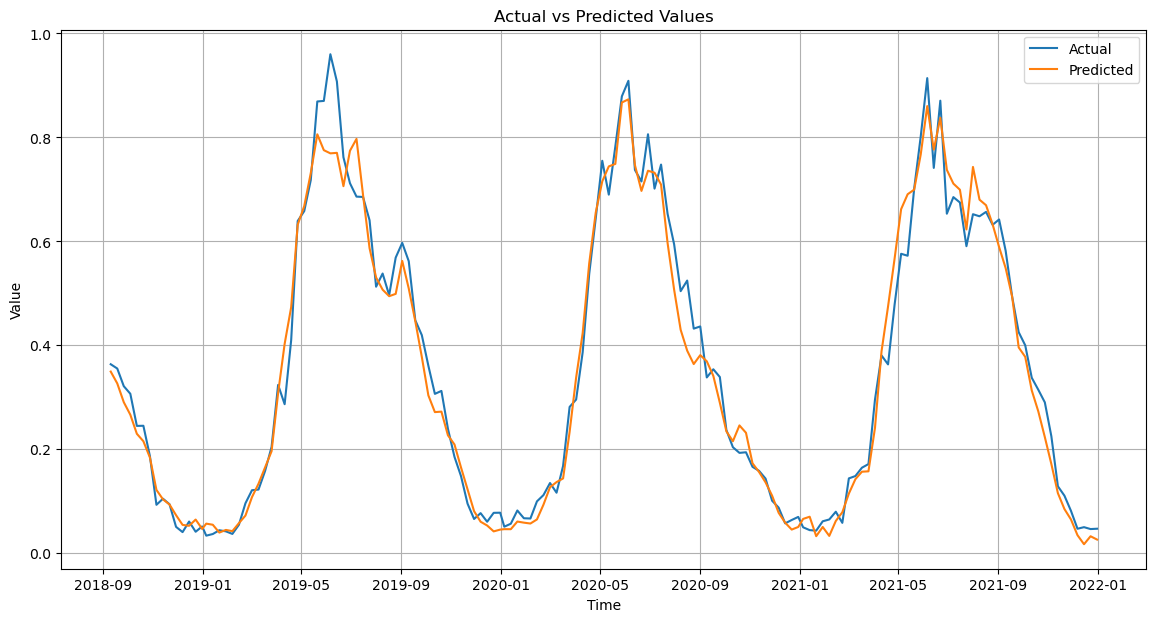

In [61]:

# Function to plot predicted vs. actual values
def plot_predicted_vs_actual1(testY, forecasts, test_index, look_back):
    plt.figure(figsize=(14, 7))
    plt.plot(sorted(test_index[look_back+1:]), testY, label='Actual')
    plt.plot(sorted(test_index[look_back+1:]), forecasts, label='Predicted')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


# Function to plot predicted vs. actual values
def plot_predicted_vs_actual(testY, forecasts, test_index, look_back):
    plt.figure(figsize=(14, 7))
    plt.plot( testY, label='Actual')
    plt.plot( forecasts, label='Predicted')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predicted_vs_actual1(testY, forecasts, test_index, look_back)